## Inicialización

In [17]:
# Cargamos las librerías que vamos a utilizar 

import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
# Importamos nuestro dataset

faces_labels = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [3]:
# Usamos el método info() para obtener información de nuestro dataset.

faces_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# Imprimimos un shape() de nuestro dataset

faces_labels.shape

(7591, 2)

In [15]:
# Comprobamos que no tengamos duplicados

faces_labels.file_name.duplicated().sum()

0

In [5]:
# Imprimimos un describe() para entender un poco la distribución de nuestras edades

faces_labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [16]:
# Imprimimos un value_counts para entender las edades más repetidas en nuestro dataset

faces_labels.real_age.value_counts(normalize=True).head(15)

30    0.041760
25    0.041497
27    0.030167
26    0.029772
28    0.028586
23    0.028060
24    0.027796
18    0.025425
16    0.025425
19    0.023712
22    0.023581
20    0.023449
32    0.022922
40    0.022000
29    0.021605
Name: real_age, dtype: float64

Text(0.5, 1.0, 'Age Boxplot')

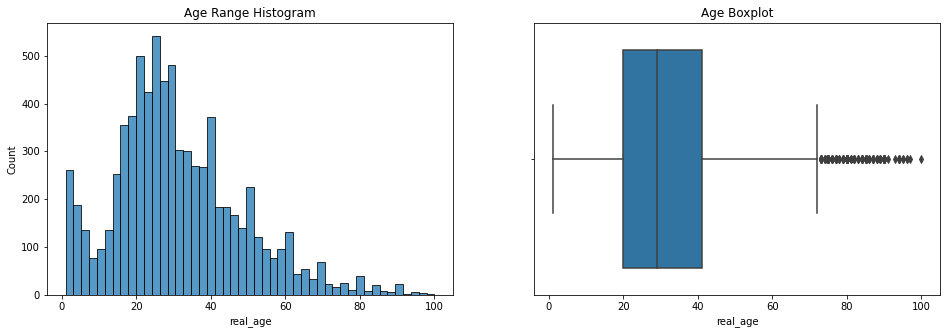

In [7]:
# Creamos dos gráficos para entender la distribución de nuestro dataset

fig, axs = plt.subplots(1,2, figsize=(16,5))

# Creamos un Histograma

sns.histplot(x='real_age',data=faces_labels,ax=axs[0])
axs[0].set_title('Age Range Histogram')

# Creamos un diagrama de caja

sns.boxplot(x='real_age',data=faces_labels,ax=axs[1])
plt.title('Age Boxplot')

In [8]:
# Creamos una función para imprimir imágenes de nuestro dataset

def print_images(df,column_1,column_2,age,number):
    new_df = df.query(column_1+ '==' + str(age))[column_2][0:number].reset_index()
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    
    for i in range(0,number):
        image = Image.open('/datasets/faces/final_files/' + new_df[column_2][i])
        array = np.array(image)
        axes[i // 5, i % 5].imshow(array)
        axes[i // 5, i % 5].set_title('Age ' + str(age))
        axes[i // 5, i % 5].axis('off')
    plt.tight_layout()
    plt.show()

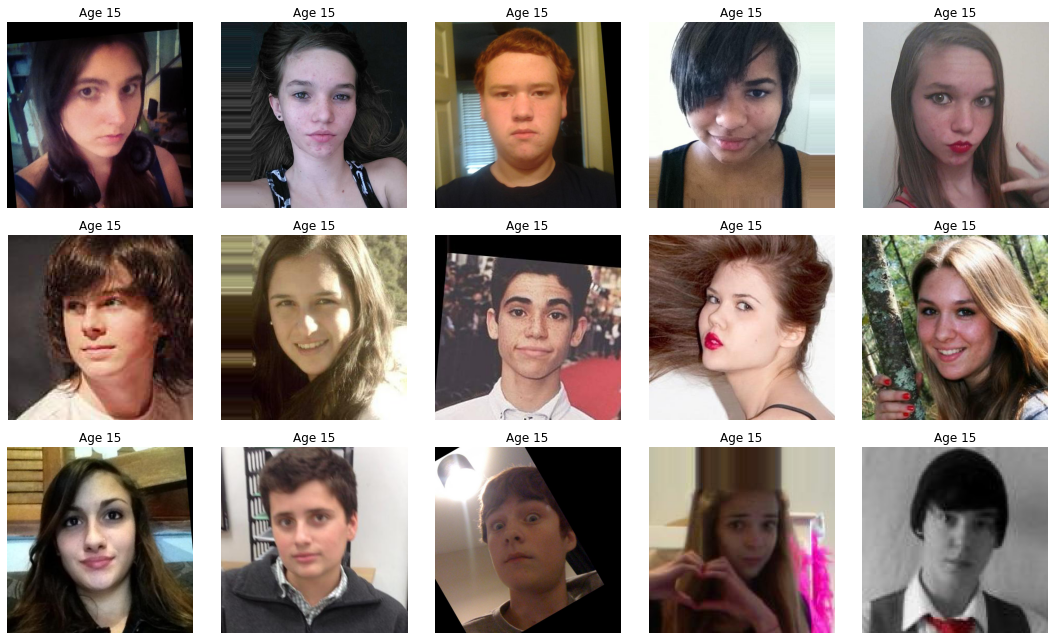

In [9]:
# Imprimimos imágenes de personas con 15 años

print_images(faces_labels,'real_age','file_name',15,15)

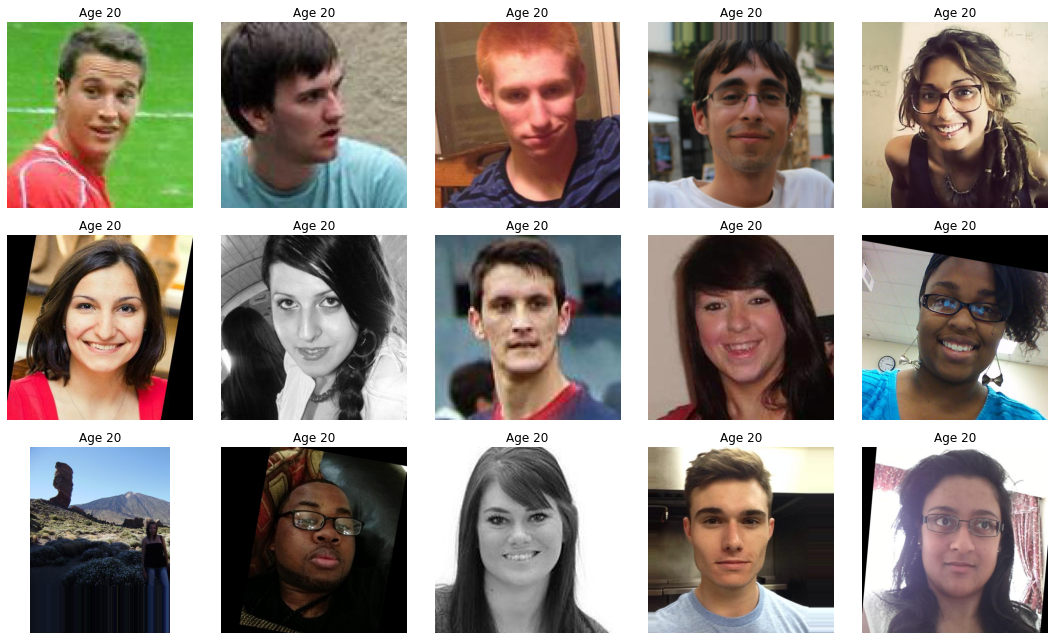

In [10]:
# Imprimimos imágenes de personas con 20 años. 

print_images(faces_labels,'real_age','file_name',20,15)

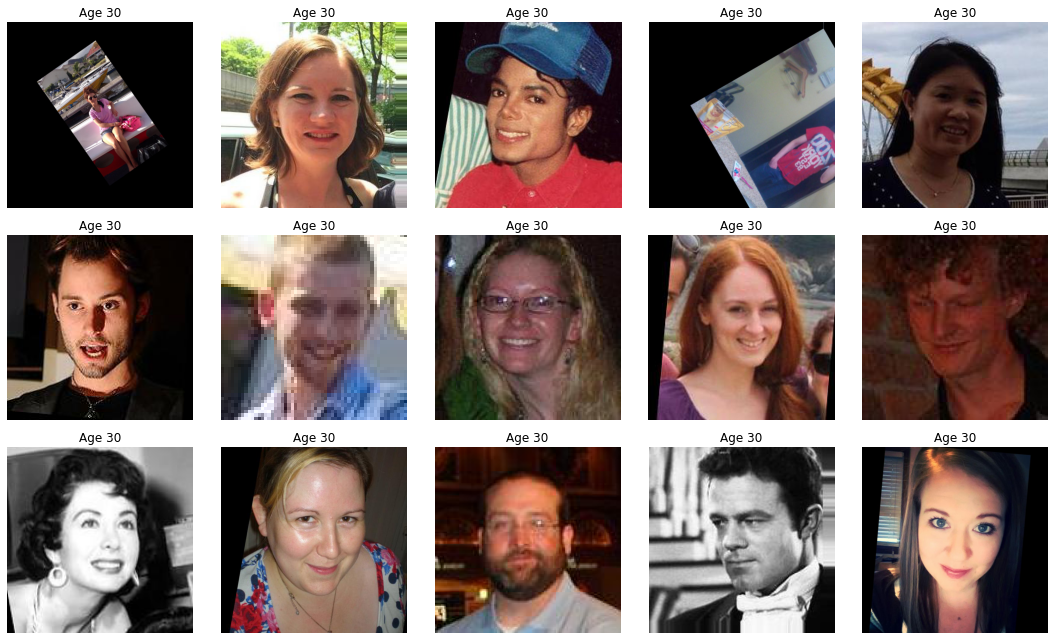

In [11]:
# Imprimimos imágenes de personas con 30 años. 

print_images(faces_labels,'real_age','file_name',30,15)

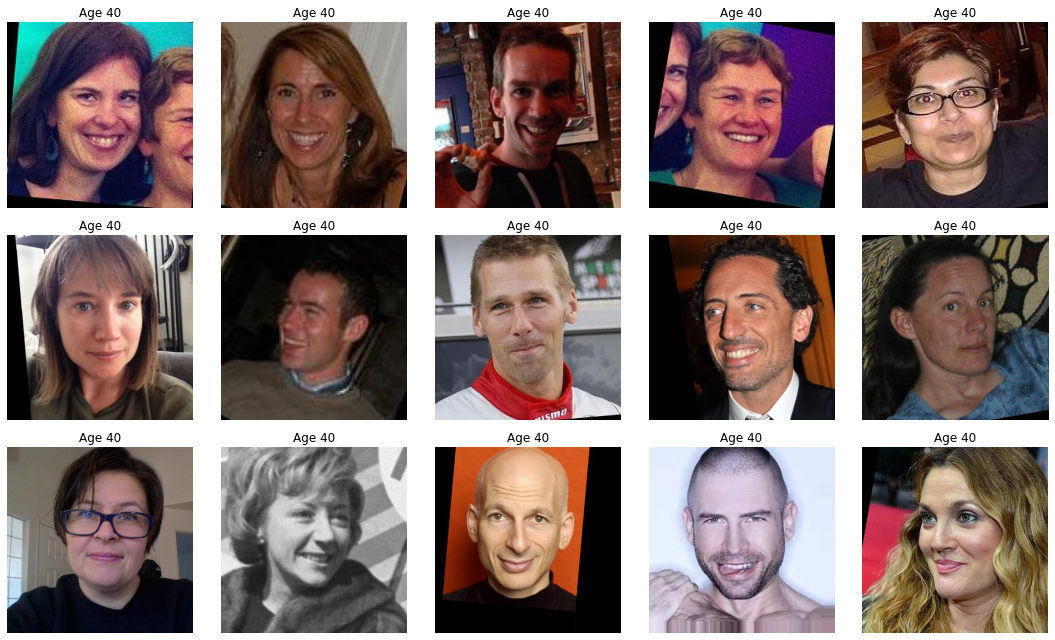

In [12]:
# Imprimimos imágenes de personas con 40 años. 

print_images(faces_labels,'real_age','file_name',40,15)

### Conclusiones

-	Tenemos un conjunto de datos con 7591 muestras y dos columnas. Una de nuestras columnas tiene la ruta de la imagen y en nuestra segunda columna tenemos la edad de la persona de la foto. 
-	No tenemos valores ausentes. 
-	No tenemos fotos duplicadas. 
-	Tenemos fotos de personas desde uno hasta los cien años. 
-	En nuestro grafico podemos observar que nuestro conjunto de datos esta sesgado hacia la derecha. Lo que nos quiere decir que no tenemos tantas fotografías para las personas entre 70 y 100 años. Podemos ver esto mismo en nuestro grafico de caja. 
-	Al ver nuestras imágenes impresas, observamos que para cada edad tenemos variedad de fotografías. Fotos de rostros tomadas de distintos ángulos y con distintos grados de luz, etc. También vemos que tenemos unas imágenes más grandes que otras. 


## Modelado

En esta seccion escribiremos las funciones que utilizaremos para entrenar nuestro modelo en la GPU. 

In [ ]:
# Definimos la función para nuestro conjunto de entrenamiento

def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(448, 448),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow

In [ ]:
# Definimos la función para nuestro conjunto de prueba

def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(448, 448),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_gen_flow

In [ ]:
# Definimos nuestra función para crear nuestro modelo

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1,activation='relu'))
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model

In [ ]:
# Definimos nuestra función para entrenar nuestro modelo

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(train_data,
              validation_data=test_data,
              verbose=2,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              )

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Preparamos nuestro scrip para entrenar el modelo en la GPU

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

"""
import inspect

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(448, 448),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(448, 448),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_gen_flow
    
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1,activation='relu'))
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model
    
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(train_data,
              validation_data=test_data,
              verbose=2,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              )

    return model
    
with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

60/60 - 17s - loss: 64.9309 - mae: 5.9986
Test MAE: 5.9986

## Conclusiones

-	Para entrenar este conjunto de datos decidimos utilizar una red ResNet50. Ya que nuestro objetivo eran las edades de las fotos, hemos creado un modelo de regresión. Hemos utilizado la función de perdida error cuadrático medio y la métrica MAE. 
-	Al cargar nuestros conjuntos de entrenamiento y prueba hemos normalizado cada conjunto en una escala de 1/255. Usamos un target size de 448x448 y un batch size de 32. Y también hemos evitado alterar las fotos originales. 
-	En nuestro modelo utilizamos un optimizador Adam de 0.0001, pesos de Imagenet, una capa de GlobalAveragePooling2D y dos capas Dense con activación Relu. 
-	En el entrenamiento hemos utilizado 20 épocas. 
-	Con este modelo hemos obtenido un MAE de 5.99 en nuestro conjunto de prueba. 
